# Tutorial
OceanSpy builds on software packages developed by the Pangeo community, in particular [xarray](http://xarray.pydata.org/en/stable/), [dask](https://dask.org/), and [xgcm](https://xgcm.readthedocs.io/en/stable/). It is preferable to have some familiarity with these packages.

In [1]:
import oceanspy as ospy

## OceanDataset
An `xarray.Dataset` (or `ds`) is the only object required to initialize an `oceanspy.OceanDataset` (or `od`).
An `od` is a collection of objects used by OceanSpy, and it can be initialized using the following command:
```python
od = ospy.OceanDataset(ds)
```
Then, you can use the OceanDataset methods to modify `od` and set the attributes used by OceanSpy (see [Import](api.rst#import)).
Alternatively, you can create a catalog (extension `.yaml`) to initialize an `od` and make it compatible with OceanSpy right away.
```python
od = ospy.open_oceandataset.from_catalog('entry_name', 'catalog_path')
```
See [Opening](api.rst#opening) to learn how to initialize an `od` using catalogs.

### Opening
Several datasets are available on SciServer (see [SciServer Access](installation.rst#sciServer-access)).
Use `open_oceandataset.from_catalog()` to open one of these datasets (see [Opening](api.rst#opening) for a list of available datasets).
Otherwise, you can run this notebook on any workstation by downloading the get_started data (less than 1Gb) and using `open_oceandataset.from_zarr()`.  
Set `SciServer = True` to run this notebook on SciServer, otherwise set `SciServer = False`.

In [2]:
SciServer = False # True: SciServer - False: local workstation
if SciServer:
    od = ospy.open_oceandataset.from_catalog('get_started')
else:
    import os
    if not os.path.isdir('oceanspy_get_started'):
        # Download only if necessary
        import subprocess
        print("Downloading and uncompressing get_started data...")
        print("...it might take a couple of minutes.")
        commands = ['wget -v -O oceanspy_get_started.tar.gz -L '
                    'https://jh.box.com/shared/static/'
                    'pw83oja1gp6mbf8j34ff0qrxp08kf64q.gz',
                    'tar xvzf oceanspy_get_started.tar.gz',
                    'rm -f oceanspy_get_started.tar.gz']
        subprocess.call('&&'.join(commands), shell=True)
    od = ospy.open_oceandataset.from_zarr('oceanspy_get_started')
    
print()
print(od)

Opening dataset from [oceanspy_get_started].

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f1081cb8eb8>

More attributes:
   .name: EGshelfIIseas2km_ASR_full
   .description: High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), 
and the Iceland and Irminger Seas (IIseas) forced by the Arctic System Reanalysis (ASR). 
Citation: 
  * Almansi et al., 2017 - JPO.
Mates: 
  * EGshelfIIseas2km_ASR_full: Full domain without variables to close budgets.
  * EGshelfIIseas2km_ASR_crop: Cropped domain with variables to close budgets.
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>


### Set functions
All attributes are stored as global attributes (strings) in the `Dataset` object, and decoded by OceanSpy.
Because of this, do not change directly attributes, but use OceanSpy's [Set](api.rst#set) functions.
For example:

In [3]:
od = od.set_name('oceandataset #1', overwrite=True)
od = od.set_description('This is my first oceandataset', overwrite=True)
print(od)

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f1081cb8eb8>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>


The advantage of storing all the attributes in the Dataset is that checkpoints can be created at any time (e.g., storing the Dataset in NetCDF format), and an OceanDataset can be easily reconstructed on any workstation. Thus, OceanSpy can be used at different stages of the post-processing.

### Modify Dataset objects
Most of OceanSpy functions modify or add variables to `od.dataset`.
However, `od.dataset` is just a mirror object constructed from `od._ds`.
If aliases have been set (e.g., the dataset `EGshelfSJsec500m_3H_hydro` uses some variable names different from OceanSpy's reference names) `od._ds` and `od.dataset` differ from each other.  
If you want to modify the Dataset without using OceanSpy, you can easily extract it from `od`, change it using `xarray`, finally you can re-initialize `od` when you want to use OceanSpy again.
Here is an example:

In [4]:
# Extract ds
ds = od.dataset

# Compute mean temperature
ds['meanTemp'] = ds['Temp'].mean('time')

# Re-initialize the OceanDataset
od = ospy.OceanDataset(ds)
print(od)
print()
print(od.dataset['meanTemp'])

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f1081b96f68>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>

<xarray.DataArray 'meanTemp' (Z: 55, Y: 154, X: 207)>
dask.array<shape=(55, 154, 207), dtype=float64, chunksize=(55, 154, 207)>
Coordinates:
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
    XC       (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
    YC       (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
  * Z        (Z) float64 -1.0 -3.5 -7.0 -11.5 ... -681.5 -696.5 -711.5 -726.5


Note: Make sure that the global attributes of the Dataset don't get lost, so you don't have to re-set the attributes of the OceanDataset.
Here is an example:

In [5]:
import xarray as xr

# Extract ds
ds = od.dataset

# Compute mean salinity
ds = xr.merge([ds, ds['S'].mean('time').rename('meanS')])

# Global attributes have been dropped
print(ds.attrs)

# Re-set global attributes
ds.attrs = od.dataset.attrs

# Re-initialize the OceanDataset
od = ospy.OceanDataset(ds)
print()
print(od)
print()
print(od.dataset['meanS'])

OrderedDict()

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f1081cb8eb8>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>

<xarray.DataArray 'meanS' (Z: 55, Y: 154, X: 207)>
dask.array<shape=(55, 154, 207), dtype=float64, chunksize=(55, 154, 207)>
Coordinates:
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
    XC       (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
    YC       (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
  * Z        (Z) float64 -1.0 -3.5 -7.0 -11.5 ... -681.5 -696.5 -711.5 -726.5


## Subsampling
There are several functions that subsample the oceandataset in different ways. For example, it is possible to extract mooring sections, conduct ship surveys, or extract particle properties (see [Subsampling](api.rst#subsampling)).
The following command extract subsets of data preserving the original grid structure (Arakawa-C grid):

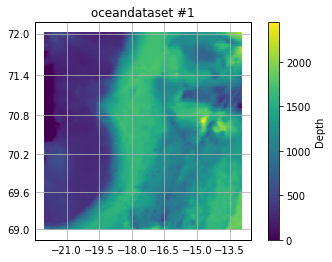

In [6]:
# Plot the original domain
%matplotlib inline
ax = od.plot.horizontal_section(varName='Depth')
tit = ax.set_title(od.name)

In [7]:
od_cut = od.subsample.cutout(XRange=[-21, -13.5],
                             YRange=[69.6, 71.4],
                             ZRange=0,
                             timeRange='2007-09-01')
od_cut = od_cut.set_name('cutout', overwrite=False)
# Alternatively, this syntax can be used:
# od_cut = ospy.subsample.cutout(od, ...)

Cutting out the oceandataset.


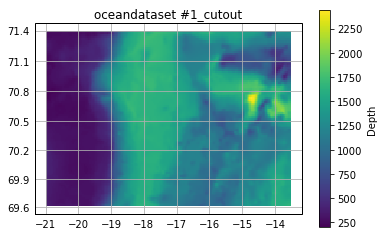

In [8]:
# Plot the cutout domain
ax = od_cut.plot.horizontal_section(varName='Depth')
tit = ax.set_title(od_cut.name)

The size of the dataset has been reduced, but the relative size of the horizontal (`X`, `Xp1`, `Y`, `Yp1`), vertical (`Z`, `Zp1`, `Zu`, `Zl`), and time dimensions (`time`, `time_midp`) is unchanged:

In [9]:
print('Original: {} Gigabytes'.format(od.dataset.nbytes*1.E-9))
print(dict(od.dataset.sizes))
print()
print('Cutout: {} Megabytes'.format(od_cut.dataset.nbytes*1.E-6))
print(dict(od_cut.dataset.sizes))

Original: 1.034784936 Gigabytes
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 55, 'Zl': 55, 'Zp1': 56, 'Zu': 55, 'time': 4, 'time_midp': 3}

Cutout: 18.010824 Megabytes
{'X': 170, 'Xp1': 171, 'Y': 93, 'Yp1': 94, 'Z': 1, 'Zl': 1, 'Zp1': 2, 'Zu': 1, 'time': 2, 'time_midp': 1}


Most of OceanSpy functions operate on staggered grids.
Therefore, `od_cut` is still compatible with OceanSpy. Several additional arguments are available (see [Subsampling](api.rst#subsampling)). For example, it is possible to get rid of staggered grids:

In [10]:
# Extract sea surface, and drop Z-axis.
od_drop = od.subsample.cutout(ZRange=0, dropAxes=True)

print()
print('Original oceandataset:')
print(dict(od.dataset.sizes))
print(od.grid)
print()
print('New oceandataset:')
print(dict(od_drop.dataset.sizes))
print(od_drop.grid)

Cutting out the oceandataset.

Original oceandataset:
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 55, 'Zl': 55, 'Zp1': 56, 'Zu': 55, 'time': 4, 'time_midp': 3}
<xgcm.Grid>
X Axis (not periodic):
  * center   X --> outer
  * outer    Xp1 --> center
Y Axis (not periodic):
  * center   Y --> outer
  * outer    Yp1 --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
time Axis (not periodic):
  * center   time_midp --> outer
  * outer    time --> center

New oceandataset:
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 1, 'Zl': 1, 'Zp1': 1, 'Zu': 1, 'time': 4, 'time_midp': 3}
<xgcm.Grid>
X Axis (not periodic):
  * center   X --> outer
  * outer    Xp1 --> center
Y Axis (not periodic):
  * center   Y --> outer
  * outer    Yp1 --> center
time Axis (not periodic):
  * center   time_midp --> outer
  * outer    time --> center


Now, the relative size of the vertical dimensions has changed (they all have size 1).

## Computing
The compute module contains functions that create new variables (see [Computing](api.rst#computing)). Most of OceanSpy functions use lazy evaluation, which means that the actual computation is not done until values are needed (e.g., when plotting).
There are two different types of compute functions:

* Fixed-name: Functions that don't require an input. The name of new variables is fixed.
* Smart-name: Functions that require an input (e.g., vector calculus). The name of new variables is based on input names.

### Fixed-name
Here we compute kinetic energy as example.
This syntax returns a dataset containing new variables:

In [11]:
ds_KE = ospy.compute.kinetic_energy(od_drop)
print(ds_KE)

Computing kinetic energy using the following parameters: {'eps_nh': 0}.
<xarray.Dataset>
Dimensions:  (X: 207, Y: 154, Z: 1, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2007-09-01 ... 2007-09-01T18:00:00
  * Z        (Z) float64 -1.0
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
Data variables:
    KE       (time, Z, Y, X) float64 dask.array<shape=(4, 1, 154, 207), chunksize=(4, 1, 154, 207)>
Attributes:
    OceanSpy_description:    This is my first oceandataset
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_name:           oceandataset #1
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho0':...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_periodic:  []


While this syntax adds new variables to `od`:

In [12]:
od_KE = od_drop.compute.kinetic_energy()
print(od_KE.dataset)

Computing kinetic energy using the following parameters: {'eps_nh': 0}.
<xarray.Dataset>
Dimensions:     (X: 207, Xp1: 208, Y: 154, Yp1: 155, Z: 1, Zl: 1, Zp1: 1, Zu: 1, time: 4, time_midp: 3)
Coordinates:
  * X           (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
  * Y           (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
  * Z           (Z) float64 -1.0
  * time        (time) datetime64[ns] 2007-09-01 ... 2007-09-01T18:00:00
    XC          (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
    XG          (Yp1, Xp1) float64 dask.array<shape=(155, 208), chunksize=(155, 208)>
    XU          (Y, Xp1) float64 dask.array<shape=(154, 208), chunksize=(154, 208)>
    XV          (Yp1, X) float64 dask.array<shape=(155, 207), chunksize=(155, 207)>
  * Xp1         (Xp1) float64 -22.04 -22.0 -21.96 ... -13.03 -12.98 -12.94
    YC          (Y, X) float64 dask.array<shape=(154, 207), chunksize=(154, 207)>
    YG          (Yp1, Xp1) float64 

Kinetic energy has been lazily evaluated so far.
We can trigger the computation by plotting the mean kinetic energy.

Computing weighted_mean.


/home/mattia/miniconda3/envs/ospy37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


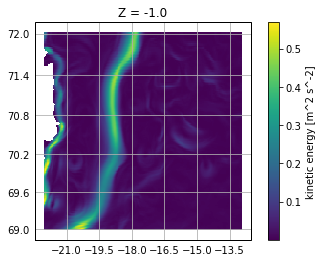

In [13]:
od_KE.plot.horizontal_section(varName='KE', meanAxes='time')

Note that OceanSpy always compute weighted means rather than regular averages!

### Smart-name
Here we compute gradients as example.
As seen above, `od.compute.gradient(...)` returns a dataset, while `od = ospy.compute.gradient(od, ...)` adds new variables to the oceandataset.
The following cell computes temperature gradients along all dimensions:

In [14]:
ds = ospy.compute.gradient(od, varNameList='Temp')
print(ds.data_vars)

Computing gradient.
Data variables:
    dTemp_dY     (time, Z, Yp1, X) float64 dask.array<shape=(4, 55, 155, 207), chunksize=(4, 55, 1, 207)>
    dTemp_dX     (time, Z, Y, Xp1) float64 dask.array<shape=(4, 55, 154, 208), chunksize=(4, 55, 154, 1)>
    dTemp_dZ     (time, Zl, Y, X) float64 dask.array<shape=(4, 55, 154, 207), chunksize=(4, 1, 154, 207)>
    dTemp_dtime  (time_midp, Z, Y, X) float64 dask.array<shape=(3, 55, 154, 207), chunksize=(3, 55, 154, 207)>


While the following code computes temperature, salinity, and density gradient along the time dimension only. 
Note that `Sigma0` needs to be computed.

In [15]:
ds = ospy.compute.gradient(od, varNameList=['Temp', 'S', 'Sigma0'],
                           axesList=['time'])
print(ds.data_vars)

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing gradient.
Data variables:
    dTemp_dtime    (time_midp, Z, Y, X) float64 dask.array<shape=(3, 55, 154, 207), chunksize=(3, 55, 154, 207)>
    dS_dtime       (time_midp, Z, Y, X) float64 dask.array<shape=(3, 55, 154, 207), chunksize=(3, 55, 154, 207)>
    dSigma0_dtime  (time_midp, Z, Y, X) float64 dask.array<shape=(3, 55, 154, 207), chunksize=(3, 55, 154, 207)>


Here is an overview of the smart-name functions:

In [16]:
print('GRADIENT')
print(ospy.compute.gradient(od, 'Temp').data_vars)
print()

print('DIVERGENCE')
print(ospy.compute.divergence(od, iName='U', jName='V', kName='W').data_vars)
print()

print('CURL')
print(ospy.compute.curl(od, iName='U', jName='V', kName='W').data_vars)
print()

print('LAPLACIAN')
print(ospy.compute.laplacian(od, varNameList='Temp').data_vars)
print()

print('WEIGHTED MEAN')
print(ospy.compute.weighted_mean(od, varNameList='Temp').data_vars)
print()

print('INTEGRAL')
print(ospy.compute.integral(od, varNameList='Temp').data_vars)
print()

GRADIENT
Computing gradient.
Data variables:
    dTemp_dY     (time, Z, Yp1, X) float64 dask.array<shape=(4, 55, 155, 207), chunksize=(4, 55, 1, 207)>
    dTemp_dX     (time, Z, Y, Xp1) float64 dask.array<shape=(4, 55, 154, 208), chunksize=(4, 55, 154, 1)>
    dTemp_dZ     (time, Zl, Y, X) float64 dask.array<shape=(4, 55, 154, 207), chunksize=(4, 1, 154, 207)>
    dTemp_dtime  (time_midp, Z, Y, X) float64 dask.array<shape=(3, 55, 154, 207), chunksize=(3, 55, 154, 207)>

DIVERGENCE
Computing divergence.
Computing gradient.
Data variables:
    dU_dX    (time, Z, Y, X) float64 dask.array<shape=(4, 55, 154, 207), chunksize=(4, 55, 154, 207)>
    dV_dY    (time, Z, Y, X) float64 dask.array<shape=(4, 55, 154, 207), chunksize=(4, 55, 154, 207)>
    dW_dZ    (time, Z, Y, X) float64 dask.array<shape=(4, 55, 154, 207), chunksize=(4, 54, 154, 207)>

CURL
Computing curl.
Computing gradient.
Computing gradient.
Computing gradient.
Computing gradient.
Data variables:
    dV_dX-dU_dY  (time, Z, Yp1, 

All new variables have been lazily evaluated so far. The following cell triggers the evaluation of the weighted mean temperature and salinity along all dimensions: 

In [17]:
ds = ospy.compute.weighted_mean(od, varNameList=['Temp', 'S'], storeWeights=False)
for var in ds.data_vars:
    print('{} = {} {}'.format(var, ds[var].values, ds[var].attrs.pop('units', '')))

Computing weighted_mean.
w_mean_Temp = 0.5421960292553059 degC
w_mean_S = 34.600691099468925 


## Plotting
Some of the plot functions have been used above. See [Plotting](api.rst#plotting) for a list of available functions.  
For example, horizontal sections are projected using the attribute `projection` of `od`.
Here we plot the mean sea surface temperature and the isobaths using different projections:

Cutting out the oceandataset.
Computing weighted_mean.
Computing weighted_mean.


/home/mattia/miniconda3/envs/ospy37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


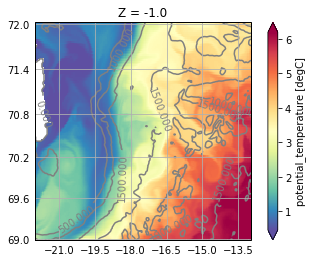

In [18]:
# After importing oceanspy,
# always set %matplotlib inline or %matplotlib notebook
# the first time that you make a plot.
%matplotlib inline 
ax = od.plot.horizontal_section(varName='Temp',
                                contourName='Depth',
                                meanAxes='time',
                                center=False,
                                cmap='Spectral_r',
                                robust=True,
                                cutout_kwargs={'ZRange': 0,
                                               'dropAxes': True})

Cutting out the oceandataset.
Computing weighted_mean.
Computing weighted_mean.


/home/mattia/miniconda3/envs/ospy37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


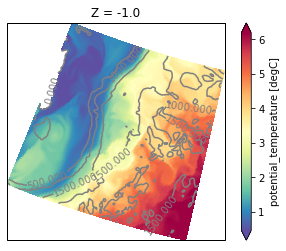

In [19]:
# Change projection
od_NPS = od.set_projection('NorthPolarStereo')
ax = od_NPS.plot.horizontal_section(varName='Temp',
                                    contourName='Depth',
                                    meanAxes=True,
                                    center=False,
                                    cmap='Spectral_r',
                                    robust=True,
                                    cutout_kwargs={'ZRange': 0,
                                                   'dropAxes': True})

## Animating
See [Animating](api.rst#animating) for a list of available functions. Plotting and animating functions have identical syntax. For example, just replace `od.plot.horizontal_section` with `od.aimate.horizontal_section` to create an animation of Sea Surface Temperature:

In [20]:
anim = od.animate.horizontal_section(varName='Temp',
                                     contourName='Depth',
                                     center=False,
                                     cmap='Spectral_r',
                                     robust=True,
                                     cutout_kwargs={'ZRange': 0,
                                                    'dropAxes': True},
                                     display=False)

# The following code is necessary to display the animation in the documentation.
# When the notebook is executed, remove the code below and set
# display=True in the command above to show the animation.
import matplotlib.pyplot as plt
dirName = 'Figs'
import os
try:
    os.mkdir(dirName)
except FileExistsError:
    pass
anim.save('Figs/tutorial.mp4')
plt.close()
!ffmpeg -loglevel panic -y -i Figs/tutorial.mp4 -filter_complex "[0:v] fps=12,scale=480:-1,split [a][b];[a] palettegen [p];[b][p] paletteuse" Figs/tutorial.gif

Cutting out the oceandataset.


![Jupyter notebook icon](Figs/tutorial.gif)